In [1]:
!unzip -qq data.zip

In [2]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class SinhalaCharDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
dataset = SinhalaCharDataset('/content/data/')
a = dataset[1]

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [5]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 231724, done.
remote: Counting objects: 100% (5395/5395), done.
remote: Compressing objects: 100% (558/558), done.
remote: Total 231724 (delta 4970), reused 5197 (delta 4828), pack-reused 226329
Receiving objects: 100% (231724/231724), 467.55 MiB | 40.18 MiB/s, done.
Resolving deltas: 100% (210060/210060), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [6]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [8]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = SinhalaCharDataset('data', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

In [12]:
# use our dataset and defined transformations
dataset = SinhalaCharDataset('data', get_transform(train=True))
dataset_test = SinhalaCharDataset('data', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-2])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-2:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [15]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 40

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [0/4]  eta: 0:00:07  lr: 0.001670  loss: 2.2362 (2.2362)  loss_classifier: 0.4821 (0.4821)  loss_box_reg: 0.8630 (0.8630)  loss_mask: 0.6225 (0.6225)  loss_objectness: 0.1175 (0.1175)  loss_rpn_box_reg: 0.1511 (0.1511)  time: 1.8033  data: 1.0809  max mem: 3993
Epoch: [0]  [3/4]  eta: 0:00:00  lr: 0.005000  loss: 2.2141 (2.1807)  loss_classifier: 0.4640 (0.4633)  loss_box_reg: 0.7905 (0.8173)  loss_mask: 0.5218 (0.5562)  loss_objectness: 0.1053 (0.1120)  loss_rpn_box_reg: 0.2103 (0.2319)  time: 0.8414  data: 0.2797  max mem: 3993
Epoch: [0] Total time: 0:00:03 (0.8720 s / it)
creating index...
index created!
Test:  [0/2]  eta: 0:00:01  model_time: 0.2820 (0.2820)  evaluator_time: 0.3733 (0.3733)  time: 0.8706  data: 0.2140  max mem: 3993
Test:  [1/2]  eta: 0:00:01  model_time: 0.2820 (0.7855)  evaluator_time: 0.3733 (0.7861)  time: 1.7096  data: 0.1314  max mem: 3993
Test: Total time: 0:00:03 (1.7877 s / it)
Averaged stats: model_time: 0.2820 (0.7855)  evaluator_time: 0.373

In [16]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [17]:
prediction

[{'boxes': tensor([[537.4140,  49.5228, 547.5473,  61.5971],
          [502.9234,  46.5058, 521.3951,  62.6474],
          [ 55.2146,  53.0305,  74.3071,  70.6583],
          [548.8145,  45.1746, 567.2749,  61.1434],
          [406.6110,  48.9489, 425.5721,  65.4328],
          [243.5757,  45.0161, 255.6528,  65.5123],
          [425.6416,  50.6738, 435.2573,  63.2626],
          [335.2026,  48.5340, 353.9572,  65.4561],
          [ 71.0398,  48.7284,  89.7929,  66.8443],
          [209.4245,  52.5937, 221.2076,  65.3376],
          [384.3569,  50.3791, 403.5931,  67.1805],
          [433.1006,  47.0756, 450.8807,  63.7814],
          [118.7328,  49.3699, 139.5289,  67.3180],
          [567.6631,  45.4938, 586.6049,  62.3553],
          [479.8112,  48.9729, 497.9498,  64.1399],
          [447.0281,  56.8708, 465.7593,  74.9536],
          [313.4132,  50.0468, 332.9968,  67.6747],
          [228.4545,  52.5649, 246.0661,  68.2224],
          [411.0203,  51.4262, 423.6501,  63.3628],
   

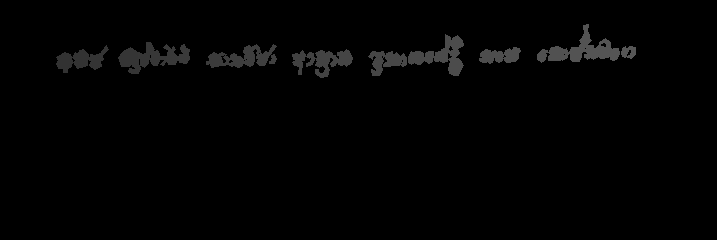

In [18]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

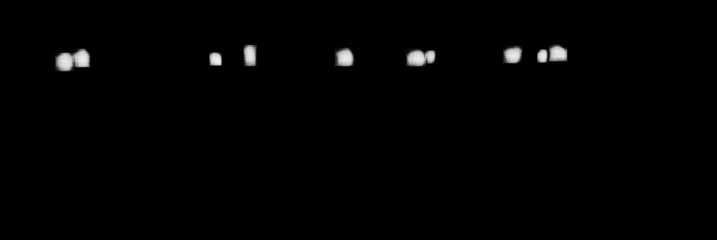

In [33]:
Image.fromarray(prediction[0]['masks'][:10, 0].sum(dim=0).mul(255).byte().cpu().numpy())